---
title: Lipschitz constant of the value function in inventory manamgent
keywords:
  - lipschitz MDPs
  - inventory management
---

In [1]:
using Plots, LaTeXStrings
using Distributions
using OffsetArrays

current_theme = :bright
current_colors = theme_palette(current_theme)
theme(current_theme)

# Discretizing the model

We discretize the continuous state model into a discrete state model by quantizing both the state and action spaces in the interval of $\delta$.

In [2]:
using MDP

const δ = 0.1
const L = 500

const S = -L:L
const A = 0:L
const W = 0:min(L,50)

point(ℓ) = ℓ * δ

discount = 0.9

0.9

We now discretizing the probability distribution of the arrival process.

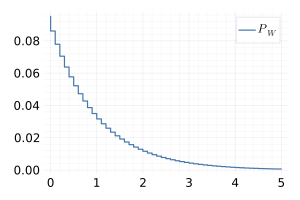

In [3]:

λ = 1
Pw_true = Exponential(λ)
Pw = OffsetArray(zeros(size(W)), W)
for w ∈ W
    if w != L
        Pw[w] = cdf(Pw_true, point(w+1)) - cdf(Pw_true, point(w))
    else
        Pw[w] = 1 - cdf(Pw_true, point(w))
    end
end
plot(point.(W), parent(Pw), linetype=:steppre, size=(300,200), label=L"$P_W$")

In [4]:
const ch = 4
const cs = 2
const p  = 5
h(s) = (s >= 0) ? ch*s : -cs*s

h (generic function with 1 method)

# Construct the Bellman update function

In [5]:
function bellmanUpdate!(v_next, π_next, v; discount=1.0)
    # Assume that v is of size 2L + 1
    # Construct a post-decision state value function
    H = OffsetArray(zeros(3L+1),-L:2L)
    # h(z) = E[ h(z-W) + γ V(z-W) ]
    for z ∈ -L:2L, w ∈ W
        next_s = clamp(z-w, -L, L)
        H[z] += ( h(z-w) + discount * v[next_s] )*Pw[w]
    end

    # V(s) = min_{a } { p*a + H(s+a) }
    for s ∈ S
        opt = 0
        val = H[s]

        for a ∈ A
            next_z = clamp(s+a, -L, 2L)
            newVal = p*a + H[next_z]
            if newVal <= val
                opt = a
                val = newVal
            end
        end
        v_next[s] = val
        π_next[s] = opt
    end
end
        

bellmanUpdate! (generic function with 1 method)

# Solve the DP

In [6]:
model = DynamicModel(bellmanUpdate!; objective=:Min)
v_initial = OffsetArray(zeros(size(S)), S)

(V,π) = valueIteration(model, v_initial; discount=discount)


[ Info: value iteration will converge in at most 186 iterations
[ Info: Reached precision 7.141323e-05 at iteration 81


([3052.4635439808926, 3046.5741483253523, 3041.201392659561, 3036.201392659561, 3031.201392659561, 3026.201392659561, 3021.201392659561, 3016.201392659561, 3011.201392659561, 3006.201392659561  …  15233.190083833815, 15270.722404898437, 15308.256505880272, 15345.792366449752, 15383.329966509486, 15420.869286191677, 15458.410305855416, 15495.953006084188, 15533.49736768321, 15571.043371676982], [500, 500, 500, 499, 498, 497, 496, 495, 494, 493  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Animate the Lipschitz constant

In [7]:

Lv = (p + max(ch,cs))/(1-discount)
anim = @animate for s ∈ -L:10:L
    upper = [ -L*Lv + V[s] - Lv*s,  L*Lv + V[s] - Lv*s ]
    lower = [  L*Lv + V[s] + Lv*s, -L*Lv + V[s] + Lv*s ]
    plt = plot(point.(S),parent(V), lw=2, legend=false)
    plot!(plt, point.([-L,L]), (upper .+ lower)/2, ribbon = (upper .- lower)/2, fillalpha=0.35, lw=0, legend=false)
    plot!(plt, point.([-L,L]), upper, color=current_colors[2], legend=false)
    plot!(plt, point.([-L,L]), lower, color=current_colors[2], legend=false)
    Min, Max = minimum(V), maximum(V)
    Height = Max - Min
    plot!(ylim=(Min - Height/4, Max + Height/4))
end


Animation("/tmp/jl_QLZlKm", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000092.png", "000093.png", "000094.png", "000095.png", "000096.png", "000097.png", "000098.png", "000099.png", "000100.png", "000101.png"])

[ Info: Saved animation to /home/adityam/Dropbox/presentations/Stochastic-Control/website/stochastic-control/julia-examples/inventory-management/lipschitz.gif


Plots.AnimatedGif("/home/adityam/Dropbox/presentations/Stochastic-Control/website/stochastic-control/julia-examples/inventory-management/lipschitz.gif")
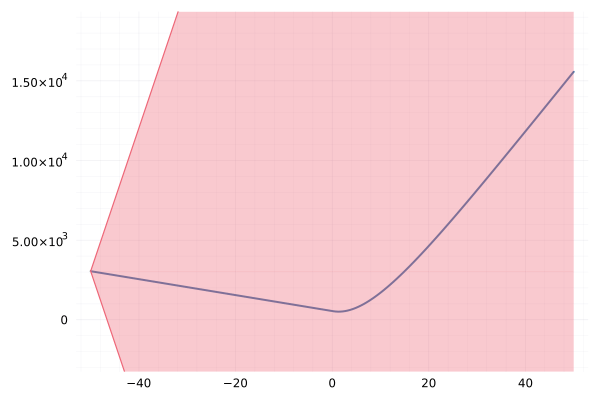

In [8]:
#| label: fig-lipschitz-animation
#| fig-cap: Animation showing the upper bound on the Lipschitz constant of the value function, computed via @thm-lipschitz-opt.
#| echo: false

gif(anim, "lipschitz.gif", fps=60)